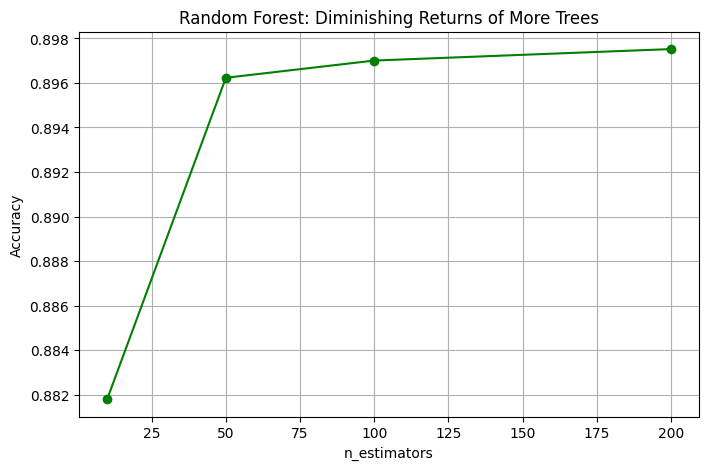

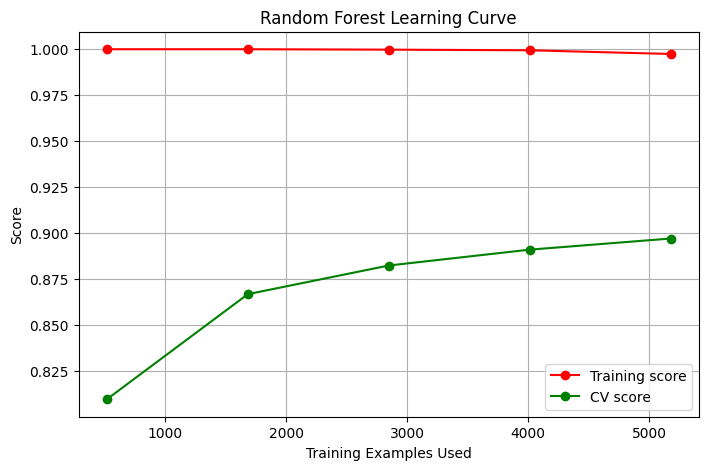

Time-Only Accuracy: 0.8896
Freq-Only Accuracy: 0.8583
Combined Accuracy: 0.9124


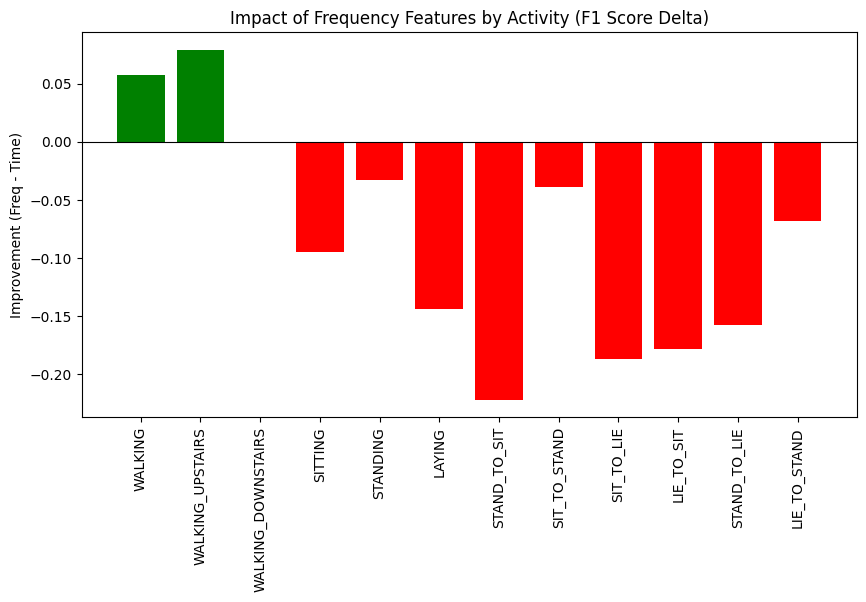

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import learning_curve
from sklearn.metrics import f1_score

train_df = pd.read_csv('../../data/activity_train.csv')
test_df = pd.read_csv('../../data/activity_test.csv')

label_map = {
    1:'WALKING', 2:'WALKING_UPSTAIRS', 3:'WALKING_DOWNSTAIRS',
    4:'SITTING', 5:'STANDING', 6:'LAYING',
    7:'STAND_TO_SIT', 8:'SIT_TO_STAND', 9:'SIT_TO_LIE',
    10:'LIE_TO_SIT', 11:'STAND_TO_LIE', 12:'LIE_TO_STAND'
}

le = LabelEncoder()

X_train = train_df.drop(columns=['activity', 'subject'], errors='ignore')
y_train = le.fit_transform(train_df['activity'])
X_test = test_df.drop(columns=['activity', 'subject'], errors='ignore')
y_test = le.transform(test_df['activity'])

n_range = [10, 50, 100, 200] 
train_scores, test_scores = validation_curve(
    RandomForestClassifier(max_depth=10, random_state=42), 
    X_train, y_train, 
    param_name="n_estimators", param_range=n_range,
    cv=3, scoring="accuracy", n_jobs=-1
)

plt.figure(figsize=(8, 5))
plt.plot(n_range, np.mean(test_scores, axis=1), marker='o', label='CV Score', color='green')
plt.title("Random Forest: Diminishing Returns of More Trees")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    X_train, y_train, cv=3, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="g", label="CV score")
plt.title("Random Forest Learning Curve")
plt.xlabel("Training Examples Used")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

t_cols = [c for c in X_train.columns if c.startswith('t')]
f_cols = [c for c in X_train.columns if c.startswith('f')]

datasets = {"Time-Only": t_cols, "Freq-Only": f_cols, "Combined": X_train.columns}
rf_best = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)

for name, cols in datasets.items():
    rf_best.fit(X_train[cols], y_train)
    acc = rf_best.score(X_test[cols], y_test)
    print(f"{name} Accuracy: {acc:.4f}")

t_cols = [c for c in X_train.columns if c.startswith('t')]
f_cols = [c for c in X_train.columns if c.startswith('f')]

rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train[t_cols], y_train)
y_pred_t = rf.predict(X_test[t_cols])
f1_t = f1_score(y_test, y_pred_t, average=None)

rf.fit(X_train[f_cols], y_train)
y_pred_f = rf.predict(X_test[f_cols])
f1_f = f1_score(y_test, y_pred_f, average=None)

diff = f1_f - f1_t
classes_idx = np.arange(len(diff))
activities = le.inverse_transform(range(len(diff)))
labels = [label_map[int(v)] for v in le.inverse_transform(classes_idx)]

plt.figure(figsize=(10, 5))
colors = ['green' if x > 0 else 'red' for x in diff]
plt.bar(activities, diff, color=colors)
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Impact of Frequency Features by Activity (F1 Score Delta)")
plt.ylabel("Improvement (Freq - Time)")
plt.xticks(rotation=90, labels=labels, ticks=classes_idx+1)
plt.show()